### This notebook was used to process glomerulus data for the client project

In [3]:
import pandas as pd
from collections import OrderedDict

HubMAP_df = pd.read_csv("./hubmap-kidney-segmentation/HuBMAP-20-dataset_information.csv")

HubMAP_df.head(5)


,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
0,aa05346ff.tiff,47340,30720,aa05346ff-anatomical-structure.json,aa05346ff.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,80,20
1,afa5e8098.tiff,43780,36800,afa5e8098-anatomical-structure.json,afa5e8098.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45
2,54f2eec69.tiff,22240,30440,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
3,d488c759a.tiff,29020,46660,d488c759a-anatomical-structure.json,d488c759a.json,68138,White,Not Hispanic or Latino,Female,66,81.5,158.8,32.2,Left,100,0
4,1e2425f28.tiff,32220,26780,1e2425f28-anatomical-structure.json,1e2425f28.json,63921,White,Not Hispanic or Latino,Male,48,131.5,193.0,35.3,Right,65,35


In [2]:
patient_dict = OrderedDict()

patients = HubMAP_df['patient_number']
images = HubMAP_df['glomerulus_segmentation_file']

i = 0
while i < len(patients):
    if patients[i] not in patient_dict.keys():
        patient_dict[patients[i]] = [images[i]]
        i += 1
    else:
        patient_dict[patients[i]].append(images[i])
        i+=1


patient_anatomical_segmentation_dict = OrderedDict()
segmentation_images = HubMAP_df['anatomical_structures_segmention_file']

j = 0
while j < len(patients):
    if patients[j] not in patient_anatomical_segmentation_dict.keys():
        patient_anatomical_segmentation_dict[patients[j]] = [segmentation_images[j]]
        j += 1
    else:
        patient_anatomical_segmentation_dict[patients[j]].append(segmentation_images[j])
        j+=1

In [3]:
for key in patient_dict.keys():
    print(key)
    print(patient_dict[key])

67347
['aa05346ff.json', 'afa5e8098.json', 'b9a3865fc.json']
67548
['54f2eec69.json', 'cb2d976f4.json']
68138
['d488c759a.json']
63921
['1e2425f28.json']
67026
['e79de561c.json', 'b2dc8411c.json']
67112
['c68fe75ea.json', '2ec3f1bb9.json']
68250
['095bf7a1f.json']
68304
['26dc41664.json', '3589adb90.json']
68555
['57512b7f1.json', '2f6ecfcdf.json']
66999
['4ef6695ce.json', '8242609fa.json']
65631
['aaa6a05cc.json']
67177
['0486052bb.json']


In [4]:
for key in patient_anatomical_segmentation_dict.keys():
    print(key)
    print(patient_anatomical_segmentation_dict[key])

67347
['aa05346ff-anatomical-structure.json', 'afa5e8098-anatomical-structure.json', 'b9a3865fc-anatomical-structure.json']
67548
['54f2eec69-anatomical-structure.json', 'cb2d976f4-anatomical-structure.json']
68138
['d488c759a-anatomical-structure.json']
63921
['1e2425f28-anatomical-structure.json']
67026
['e79de561c-anatomical-structure.json', 'b2dc8411c-anatomical-structure.json']
67112
['c68fe75ea-anatomical-structure.json', '2ec3f1bb9-anatomical-structure.json']
68250
['095bf7a1f-anatomical-structure.json']
68304
['26dc41664-anatomical-structure.json', '3589adb90-anatomical-structure.json']
68555
['57512b7f1-anatomical-structure.json', '2f6ecfcdf-anatomical-structure.json']
66999
['4ef6695ce-anatomical-structure.json', '8242609fa-anatomical-structure.json']
65631
['aaa6a05cc-anatomical-structure.json']
67177
['0486052bb-anatomical-structure.json']


#### 1. Calculate glomerulus size and eccentricity for each Json files.

In [22]:
#!pip install shapely
import math
import pandas as pd
import os
from collections import OrderedDict
import json
from shapely.geometry import Polygon, shape

def glomerulus_size(coords):
    """
    Use Shoelace formula to calculate polygon area based on coordinates
    reference: https://en.wikipedia.org/wiki/Shoelace_formula
    input: coordinates of a polygon
    return: area
    """
    area = 0.0
    if len(coords) > 2:
        x = [c[0] for c in coords]
        y = [c[1] for c in coords]
        sum_area = 0.0
        for i in range(len(coords)):
            sum_area += (y[i] + y[(i + 1) % len(coords)]) * (x[i] - x[(i + 1) % len(coords)])
        area = abs(sum_area / 2.0)
    return area

def glomerulus_ecc(coords):
    """
    The shape of glomerulus is close to a ecclipse. So, we are using the eccentricity of ecclipse
    to describe the shape of glomeruli. 
    
    reference: https://en.wikipedia.org/wiki/Eccentricity_(mathematics)
    input: coordinates of a polygon
    return: eccentricity
    """ 
    x = [c[0] for c in coords]
    y = [c[1] for c in coords]
    max_x = max(x)
    min_x = min(x)
    max_y = max(y)
    min_y = min(y)
    width = max_x - min_x
    height = max_y - min_y

    if width > height:
        a = width/2
        b = height/2
        ecc = math.sqrt(1 - b**2/a**2)
    elif width < height:
        a = height/2
        b = width/2
        ecc = math.sqrt(1 - b**2/a**2)
    elif width == height:
        ecc = 0
        #print("height equals width")
    return ecc


def main():

    folder_path = './hubmap-kidney-segmentation/train_test' 

    # The following piece of code was to separate regular jason files with anatomical json files. 
    json_files = []
    anatomical_structure_files = []
    
    file_names = sorted(os.listdir(folder_path)) 

    for file_name in file_names:
        if file_name.endswith('.json'):
            if '-anatomical-structure.json' in file_name:
                anatomical_structure_files.append(file_name)
            else:
                json_files.append(file_name)
                
    from collections import OrderedDict

    size_dict = OrderedDict() # define a dictinary to record the sizes of the glumeruli of each sample
    ecc_dict = OrderedDict() # dfine a dic to record the eccentricity of the glumeruli of each sample
    

    # Loop through the list of filenames and open each file
    for file_name in json_files:
        #print("Patient ID: {}".format(file_name))

        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            data = json.load(file) # Load GeoJSON data from a file
            
            # define two lists to store the sizes and eccentricities of the glomeruli of each sample
            list_size = []
            list_ecc = []
            
            # Iterate over the features and compute area and eccentricity for each glomerulus
            for feature in data:
                if feature["geometry"]["type"] == "Polygon":
                    coords = feature["geometry"]["coordinates"][0]
                    size = round(glomerulus_size(coords),2)
                    list_size.append(size)
                    
                    ecc = round(glomerulus_ecc(coords),2)
                    list_ecc.append(ecc)
                    #print("Area: {} Ecc: {}".format(size, shape))
            
            # Store the sizes and eccentricities of the glomeruli of each sample as values in each dictionary
            size_dict[file_name] = list_size
            ecc_dict[file_name] = list_ecc
    
    
    #write the sizes and eccentricitites of the glomeruli of all samples into files
    import csv
    import itertools
    with open('Glomerulus_sizes_json_20samples.csv','w', newline = '') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(size_dict.keys())
        for value in itertools.zip_longest(*size_dict.values()):
            writer.writerow(value)          
    
   
    with open('Glomerulus_eccentricities_json_20samples.csv','w', newline = '') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(ecc_dict.keys())
        for value in itertools.zip_longest(*ecc_dict.values()):
            writer.writerow(value)          

if __name__ == "__main__":
    #main()        
        
        

#### 2.  Calculate glomerulus size and eccentricity for each patient.

In [23]:
# This program was used to calculate glomerulus area and eccentricity in images.

#!pip install shapely
import math

def glomerulus_size(coords):
    """
    Use Shoelace formula to calculate polygon area based on coordinates
    reference: https://en.wikipedia.org/wiki/Shoelace_formula
    input: coordinates of a polygon
    return: area
    """
    area = 0.0
    if len(coords) > 2:
        x = [c[0] for c in coords]
        y = [c[1] for c in coords]
        sum_area = 0.0
        for i in range(len(coords)):
            sum_area += (y[i] + y[(i + 1) % len(coords)]) * (x[i] - x[(i + 1) % len(coords)])
        area = abs(sum_area / 2.0)
    return area

def glomerulus_ecc(coords):
    """
    The shape of glomerulus is close to a ecclipse. So, we are using the eccentricity of ecclipse
    to describe the shape of glomeruli. 
    
    reference: https://en.wikipedia.org/wiki/Eccentricity_(mathematics)
    input: coordinates of a polygon
    return: eccentricity
    """ 
    x = [c[0] for c in coords]
    y = [c[1] for c in coords]
    max_x = max(x)
    min_x = min(x)
    max_y = max(y)
    min_y = min(y)
    width = max_x - min_x
    height = max_y - min_y

    if width > height:
        a = width/2
        b = height/2
        ecc = math.sqrt(1 - b**2/a**2)
    elif width < height:
        a = height/2
        b = width/2
        ecc = math.sqrt(1 - b**2/a**2)
    elif width == height:
        ecc = 0
        #print("height equals width")
    return ecc


def main():

    folder_path = './hubmap-kidney-segmentation/train_test' 

    # The following piece of code was to separate regular jason files with anatomical json files. 
    json_files = []
    anatomical_structure_files = []
    
    file_names = sorted(os.listdir(folder_path)) 

    for file_name in file_names:
        if file_name.endswith('.json'):
            if '-anatomical-structure.json' in file_name:
                anatomical_structure_files.append(file_name)
            else:
                json_files.append(file_name)
 
    size_dict = OrderedDict() # define a dictinary to record the sizes of the glumeruli of each sample
    ecc_dict = OrderedDict() # dfine a dic to record the eccentricity of the glumeruli of each sample
    
    # Loop through the list of filenames and open each file
    for file_name in json_files:
        #print("Patient ID: {}".format(file_name))

        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            data = json.load(file) # Load GeoJSON data from a file
            
            # define two lists to store the sizes and eccentricities of the glomeruli of each sample
            list_size = []
            list_ecc = []
            
            # Iterate over the features and compute area and eccentricity for each glomerulus
            for feature in data:
                if feature["geometry"]["type"] == "Polygon":
                    coords = feature["geometry"]["coordinates"][0]
                    size = round(glomerulus_size(coords),2)
                    list_size.append(size)
                    
                    ecc = round(glomerulus_ecc(coords),2)
                    list_ecc.append(ecc)
                    #print("Area: {} Ecc: {}".format(size, shape))
            
            # Store the sizes and eccentricities of the glomeruli of each sample as values in each dictionary
            for key in patient_dict.keys():
                if file_name in patient_dict[key] and key not in size_dict.keys():
                    size_dict[key] = list_size
                elif file_name in patient_dict[key] and key in size_dict.keys():
                    size_dict[key].extend(list_size)
            
            for key in patient_dict.keys():
                if file_name in patient_dict[key] and key not in ecc_dict.keys():
                    ecc_dict[key] = list_ecc
                elif file_name in patient_dict[key] and key in ecc_dict.keys():
                    ecc_dict[key].extend(list_ecc)
    
    
    #write the sizes and eccentricitites of the glomeruli of all samples into files
    import csv
    import itertools
    with open('Glomerulus_sizes_patient_20samples.csv','w', newline = '') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(size_dict.keys())
        for value in itertools.zip_longest(*size_dict.values()):
            writer.writerow(value)          
    
   
    with open('Glomerulus_eccentricities_patient_20samples.csv','w', newline = '') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(ecc_dict.keys())
        for value in itertools.zip_longest(*ecc_dict.values()):
            writer.writerow(value)          

if __name__ == "__main__":
    #main()        
        
        

#### 3. Calculate the area of each image

In [24]:
#!pip install shapely
import math
import pandas as pd
import os
from collections import OrderedDict
import json
from shapely.geometry import Polygon, shape


def polygon_size(coords):
    """
    Use Shoelace formula to calculate polygon area based on coordinates
    reference: https://en.wikipedia.org/wiki/Shoelace_formula
    input: coordinates of a polygon
    return: area
    """
    area = 0.0
    if len(coords) > 2:
        x = [c[0] for c in coords]
        y = [c[1] for c in coords]
        sum_area = 0.0
        for i in range(len(coords)):
            sum_area += (y[i] + y[(i + 1) % len(coords)]) * (x[i] - x[(i + 1) % len(coords)])
        area = abs(sum_area / 2.0)
    return area

def glomerulus_ecc(coords):
    """
    The shape of glomerulus is close to a ecclipse. So, we are using the eccentricity of ecclipse
    to describe the shape of glomeruli. 
    
    reference: https://en.wikipedia.org/wiki/Eccentricity_(mathematics)
    input: coordinates of a polygon
    return: eccentricity
    """ 
    x = [c[0] for c in coords]
    y = [c[1] for c in coords]
    max_x = max(x)
    min_x = min(x)
    max_y = max(y)
    min_y = min(y)
    width = max_x - min_x
    height = max_y - min_y

    if width > height:
        a = width/2
        b = height/2
        ecc = math.sqrt(1 - b**2/a**2)
    elif width < height:
        a = height/2
        b = width/2
        ecc = math.sqrt(1 - b**2/a**2)
    elif width == height:
        ecc = 0
        #print("height equals width")
    return ecc


def main():

    folder_path = './hubmap-kidney-segmentation/train_test' 

    # The following piece of code was to separate regular jason files with anatomical json files. 
    json_files = []
    anatomical_structure_files = []
    
    file_names = sorted(os.listdir(folder_path)) 

    for file_name in file_names:
        if file_name.endswith('.json'):
            if '-anatomical-structure.json' in file_name:
                anatomical_structure_files.append(file_name)
 

    cortex_dict = OrderedDict()
    cortext_dict_json = OrderedDict()
    
    # The following piece of code was used to calcute the cortex area of the kidney segmentation of patient
   
    from shapely.geometry import MultiPolygon
    
    for file_name in anatomical_structure_files:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            data = json.load(file) # Load GeoJSON data from a file
            
            list_cortex = []
        # Loop over the features in the file
            for feature in data:
                # Check if the feature is a polygon in the cortex
                if feature["geometry"]["type"] == "Polygon" and feature['properties']['classification']['name'] == 'Cortex':
                    # Extract the coordinates of the polygon
                    coords = feature['geometry']['coordinates'][0]
                    # Calculate the area of the polygon using the Shoelace formula
                    area = round(polygon_size(coords),2)
                    list_cortex.append(area)
            
            cortext_dict_json[file_name] = list_cortex
            
            for key in patient_anatomical_segmentation_dict.keys():
                if file_name in patient_anatomical_segmentation_dict[key] and key not in cortex_dict.keys():
                    cortex_dict[key] = list_cortex
                elif file_name in patient_anatomical_segmentation_dict[key] and key in cortex_dict.keys():
                    cortex_dict[key].extend(list_cortex)

    #write the sizes and eccentricitites of the glomeruli of all samples into files
    import csv
    import itertools

    with open('Cortex_area_patient_20samples.csv','w', newline = '') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(cortex_dict.keys())
        for value in itertools.zip_longest(*cortex_dict.values()):
            writer.writerow(value)          
 
    with open('Cortex_area_Json_20samples.csv','w', newline = '') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(cortext_dict_json.keys())
        for value in itertools.zip_longest(*cortext_dict_json.values()):
            writer.writerow(value)         

if __name__ == "__main__":
    #main()        

Calculate the area of the Json file aaa6a05cc-anatomical-structure.json, which is a multipolygon, it causes problems when included in above code. So I calculated the area of the multipolygon separately.

In [23]:
from shapely.geometry import Polygon, MultiPolygon

# Define the coordinates from the JSON file
coordinates = [
    [
        [5987, 1052],
        [5651, 1244],
        [5627, 1244],
        [4497, 3191],
        [3776, 4105],
        [2791, 5523],
        [2190, 6292],
        [2190, 6316],
        [1060, 7349],
        [1036, 7349],
        [1036, 7398],
        [1036, 7422],
        [1036, 7494],
        [1036, 8431],
        [1036, 8455],
        [1036, 8479],
        [1204, 12181],
        [1853, 14344],
        [1853, 14368],
        [1877, 14368],
        [2730, 16683],
        [2783, 16683],
        [3955, 16417],
        [4008, 16417],
        [5980, 15671],
        [6324, 14535],
        [6564.28, 12639.67],
        [6084, 11083],
        [6052, 10649],
        [6088, 9902],
        [6305, 9219],
        [6696, 8829],
        [7424, 8042],
        [7623, 7920],
        [7837, 7996],
        [8343, 8311],
        [9473, 8071],
        [10314, 7830],
        [10338, 7830],
        [10843, 7494],
        [11299, 6244],
        [11107, 5162],
        [10602, 3984],
        [10602, 3960],
        [9833, 2975],
        [9809, 2927],
        [9761, 2879],
        [9689, 2855],
        [8728, 2109],
        [8704, 1677],
        [8728, 1653],
        [8800, 1388],
        [8343, 1244],
        [7694, 1124],
        [7718, 1461],
        [6877, 1533],
        [6853, 1533],
        [6324, 1172],
        [5987, 1052]
    ],
    [
        [6564.28, 12639.67],
        [6565, 12642],
        [6565, 12634],
        [6564.28, 12639.67]
    ]
]

# Create a list of polygons
polygons = [Polygon(coords) for coords in coordinates]

# Create a shapely MultiPolygon object
mp = MultiPolygon(polygons)

# Calculate the area
area = mp.area

print("Area of multipolygon:", round(area, 2))


Area of multipolygon: 87564553.26


#### 4. Find the coordinates of the center of each polygon in Json files.

In [25]:

    
def main():

    folder_path = './hubmap-kidney-segmentation/train_test' 

    # The following piece of code was to separate regular jason files with anatomical json files. 
    json_files = []
    #anatomical_structure_files = []
    
    file_names = sorted(os.listdir(folder_path)) 

    for file_name in file_names:
        if file_name.endswith('.json'):
            if '-anatomical-structure.json' in file_name:
                pass
            else:
                json_files.append(file_name)
    
    
    from collections import OrderedDict

    center_dict = OrderedDict() 


    
    import json
    from shapely.geometry import shape

    for file_name in json_files:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            data = json.load(file) # Load GeoJSON data from a file
        
        list_center_x = []
        list_center_y = []
        
        for feature in data:
            if feature["geometry"]["type"] == "Polygon":
                polygon = shape(feature['geometry'])
                # get the center of the polygon
                center = polygon.centroid
                # print the center coordinates
                list_center_x.append(round(center.x, 2))
                list_center_y.append(round(center.y, 2))
                #print('Polygon center:', center.x, center.y)
        center_dict[file_name + " x"] = list_center_x 
        center_dict[file_name + " y"] = list_center_y
        
    import csv
    import itertools
    with open('Glomerulus_center_json_20samples.csv','w', newline = '') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(center_dict.keys())
        for value in itertools.zip_longest(*center_dict.values()):
            writer.writerow(value)            
              

if __name__ == "__main__":
    #main()        

#### 5. Calculate density of the glomeruli in each image

In [26]:
cortex_json_df = pd.read_csv("./Cortex_area_Json_20samples.csv")
glomerulus_size_df = pd.read_csv("./Glomerulus_sizes_json_20samples.csv")

from collections import OrderedDict

density_dict = OrderedDict() 


import numpy as np

for file_name in cortex_json_df.columns:
    file_name_json = file_name.split("-")[0] + ".json"
    cortex_json_df[file_name] = np.nan_to_num(cortex_json_df[file_name], nan=0)
    
    glomerulus_size_df[file_name_json] = np.nan_to_num(glomerulus_size_df[file_name_json], nan=0)
    density = sum(glomerulus_size_df[file_name_json])/sum(cortex_json_df[file_name])
    
    print("density is: ", round(density, 2))
    density_dict[file_name] = density
    
import csv
import itertools
with open('Glomerulus_density_json_20samples.csv','w', newline = '') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(density_dict.keys())
    writer.writerow(density_dict.values())
      
                  

density is:  0.05
density is:  0.06
density is:  0.05
density is:  0.05
density is:  0.02
density is:  0.01
density is:  0.07
density is:  0.03
density is:  0.02
density is:  0.04
density is:  0.05
density is:  0.02
density is:  0.05
density is:  0.05
density is:  0.01
density is:  0.06
density is:  0.03
density is:  0.05
density is:  0.04
density is:  0.06


#### 6. Calculate density of the glomeruli for each patient

In [27]:
cortex_json_df = pd.read_csv("./Cortex_area_patient_20samples.csv")
glomerulus_size_df = pd.read_csv("./Glomerulus_sizes_patient_20samples.csv")

from collections import OrderedDict

density_dict = OrderedDict() 


import numpy as np

for file_name in cortex_json_df.columns:
    cortex_json_df[file_name] = np.nan_to_num(cortex_json_df[file_name], nan=0)
    glomerulus_size_df[file_name] = np.nan_to_num(glomerulus_size_df[file_name], nan=0)
    density = sum(glomerulus_size_df[file_name])/sum(cortex_json_df[file_name])
    
    print("density is: ", round(density, 2))
    density_dict[file_name] = density
    
import csv
import itertools
with open('Glomerulus_density_patient_20samples.csv','w', newline = '') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(density_dict.keys())
    writer.writerow(density_dict.values())

density is:  0.05
density is:  0.06
density is:  0.05
density is:  0.07
density is:  0.03
density is:  0.04
density is:  0.05
density is:  0.06
density is:  0.06
density is:  0.05
density is:  0.05
density is:  0.04


In [28]:
def main():

    folder_path = './hubmap-kidney-segmentation/train_test' 

    # The following piece of code was to separate regular jason files with anatomical json files. 
    json_files = []
    anatomical_structure_files = []
    
    file_names = sorted(os.listdir(folder_path)) 

    for file_name in file_names:
        if file_name.endswith('.json'):
            if '-anatomical-structure.json' in file_name:
                anatomical_structure_files.append(file_name)
 
    cortext_dict_json = OrderedDict()
    
   
    for file_name in anatomical_structure_files:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            data = json.load(file) # Load GeoJSON data from a file
            
            list_cortex_x = []
            list_cortex_y = []
        # Loop over the features in the file
            for feature in data:
                # Check if the feature is a polygon in the cortex
                if feature["geometry"]["type"] == "Polygon" and feature['properties']['classification']['name'] == 'Cortex':
                    # Extract the coordinates of the polygon
                    coords = feature['geometry']['coordinates'][0]
                    # Calculate the area of the polygon using the Shoelace formula
                    for coord in coords:
                        list_cortex_x.append(coord[0])
                        list_cortex_y.append(coord[1])
        
        cortext_dict_json[file_name + '_x']=list_cortex_x
        cortext_dict_json[file_name + '_y']=list_cortex_y
            
    #write the sizes and eccentricitites of the glomeruli of all samples into files
    import csv
    import itertools

 
    with open('Cortex_coords_Json_20samples.csv','w', newline = '') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(cortext_dict_json.keys())
        for value in itertools.zip_longest(*cortext_dict_json.values()):
            writer.writerow(value)         

if __name__ == "__main__":
    #main()        

### Calculate glomerulus size and eccentricity of extra data

In [5]:
#!pip install shapely
import math
import pandas as pd
import os
from collections import OrderedDict
import json
from shapely.geometry import Polygon, shape

def glomerulus_size(coords):
    """
    Use Shoelace formula to calculate polygon area based on coordinates
    reference: https://en.wikipedia.org/wiki/Shoelace_formula
    input: coordinates of a polygon
    return: area
    """
    area = 0.0
    if len(coords) > 2:
        x = [c[0] for c in coords]
        y = [c[1] for c in coords]
        sum_area = 0.0
        for i in range(len(coords)):
            sum_area += (y[i] + y[(i + 1) % len(coords)]) * (x[i] - x[(i + 1) % len(coords)])
        area = abs(sum_area / 2.0)
    return area

def glomerulus_ecc(coords):
    """
    The shape of glomerulus is close to a ecclipse. So, we are using the eccentricity of ecclipse
    to describe the shape of glomeruli. 
    
    reference: https://en.wikipedia.org/wiki/Eccentricity_(mathematics)
    input: coordinates of a polygon
    return: eccentricity
    """ 
    x = [c[0] for c in coords]
    y = [c[1] for c in coords]
    max_x = max(x)
    min_x = min(x)
    max_y = max(y)
    min_y = min(y)
    width = max_x - min_x
    height = max_y - min_y

    if width > height:
        a = width/2
        b = height/2
        ecc = math.sqrt(1 - b**2/a**2)
    elif width < height:
        a = height/2
        b = width/2
        ecc = math.sqrt(1 - b**2/a**2)
    elif width == height:
        ecc = 0
        #print("height equals width")
    return ecc


def main():

    folder_path = './extra_data/Glomerulus_files' 

    # The following piece of code was to separate regular jason files with anatomical json files. 
    json_files = []
    anatomical_structure_files = []
    
    file_names = sorted(os.listdir(folder_path)) 

    for file_name in file_names:
        if file_name.endswith('.json'):
            if '-anatomical-structure.json' in file_name:
                anatomical_structure_files.append(file_name)
            else:
                json_files.append(file_name)
                
    from collections import OrderedDict

    size_dict = OrderedDict() # define a dictinary to record the sizes of the glumeruli of each sample
    ecc_dict = OrderedDict() # dfine a dic to record the eccentricity of the glumeruli of each sample
    

    # Loop through the list of filenames and open each file
    for file_name in json_files:
        #print("Patient ID: {}".format(file_name))

        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            data = json.load(file) # Load GeoJSON data from a file
            
            # define two lists to store the sizes and eccentricities of the glomeruli of each sample
            list_size = []
            list_ecc = []
            
            # Iterate over the features and compute area and eccentricity for each glomerulus
            for feature in data:
                if feature["geometry"]["type"] == "Polygon":
                    coords = feature["geometry"]["coordinates"][0]
                    size = round(glomerulus_size(coords),2)
                    list_size.append(size)
                    
                    ecc = round(glomerulus_ecc(coords),2)
                    list_ecc.append(ecc)
                    #print("Area: {} Ecc: {}".format(size, shape))
            
            # Store the sizes and eccentricities of the glomeruli of each sample as values in each dictionary
            size_dict[file_name] = list_size
            ecc_dict[file_name] = list_ecc
    
    
    #write the sizes and eccentricitites of the glomeruli of all samples into files
    import csv
    import itertools
    with open('extra_Glomerulus_sizes_json.csv','w', newline = '') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(size_dict.keys())
        for value in itertools.zip_longest(*size_dict.values()):
            writer.writerow(value)          
    
   
    with open('extra_Glomerulus_eccentricities_json.csv','w', newline = '') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(ecc_dict.keys())
        for value in itertools.zip_longest(*ecc_dict.values()):
            writer.writerow(value)          

if __name__ == "__main__":
    #main()        
        
        

In [20]:
import os

def main():
    
    
    folder_path = './extra_data/DataFromHubMAP' 

    
    
    file_names = sorted(os.listdir(folder_path)) 
    
    folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

    print(folders)  
    
    for folder in folders:
        folder_files = os.listdir(os.path.join(folder_path, folder))
        print(folder_files[0],"\t",folder_files[1])
        
 
if __name__ == "__main__":
    main() 

['HBM227.THVC.554', 'HBM264.XSVF.528', 'HBM276.PGFS.693', 'HBM296.RLWW.755', 'HBM324.ZGZM.874', 'HBM344.LLLV.539', 'HBM362.PTQJ.743', 'HBM389.MBWW.346', 'HBM463.JRTB.582', 'HBM623.RPMC.638', 'HBM627.RSGW.898', 'HBM636.GVWP.354', 'HBM636.ZPTS.368', 'HBM649.DLZF.463', 'HBM649.XFQG.775', 'HBM662.PMPZ.644', 'HBM673.JJRZ.435', 'HBM676.SNVK.793', 'HBM725.PDDC.788', 'HBM783.GDKK.879', 'HBM783.GJWP.694', 'HBM832.FQKR.463', 'HBM833.DBGG.252', 'HBM849.XMPC.398', 'HBM874.RZDW.757', 'HBM875.QHDJ.259', 'HBM879.CDHB.995', 'HBM958.GHFM.676', 'HBM979.HDZH.896', 'HBM984.PMZN.942']
HBM227.THVC.544.tsv 	 VAN0032-RK-4-5-PAS-glomerulus-annotations.json
HBM264.XSVF.528.tsv 	 VAN0016-LK-202-89-PAS-glomerulus-annotations.json
HBM276.PGFS.693.tsv 	 VAN0014-LK-207-2-PAS-glomerulus-annotations.json
HBM296.RLWW.755.tsv 	 VAN0034-RK-6-5-PAS-glomerulus-annotations.json
HBM324.ZGZM.874.tsv 	 VAN0034-RK-7-7-PAS-glomerulus-annotations.json
HBM344.LLLV.539.tsv 	 VAN0029-RK-2-80-PAS-glomerulus-annotations.json
HBM362.PT

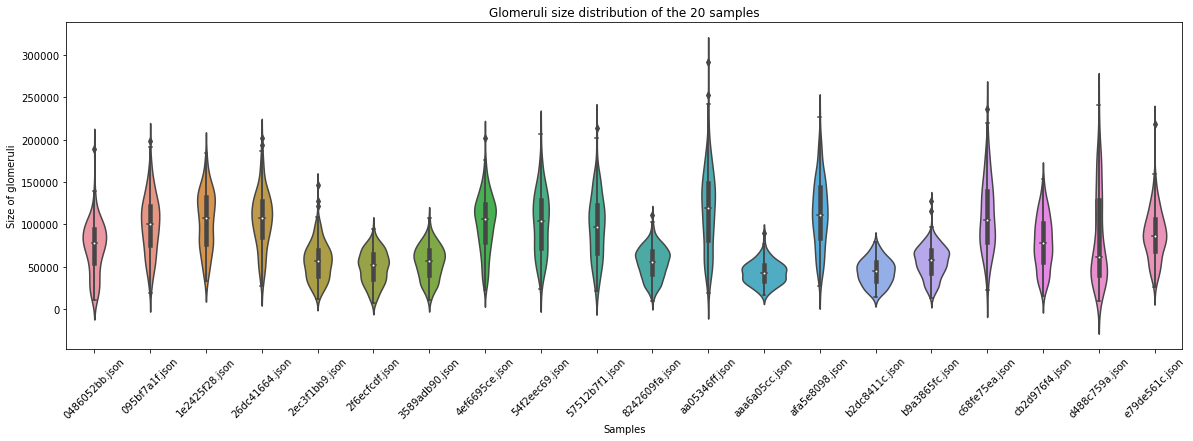

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the CSV file
df = pd.read_csv('./Final_files/Glomerulus_sizes_json_20samples.csv')

# Set the figure size
fig, ax = plt.subplots(figsize=(20, 6))

# Create the violin plot using seaborn
sns.violinplot(data=df, ax=ax)
# Add a scatter plot to show all the data points
#sns.stripplot(data=df, jitter=True, color='black', size=3, ax=ax)
# Add a boxplot to show the quartiles and median
sns.boxplot(data=df, ax=ax, width=0.1, boxprops=dict(facecolor='None'))

# Add labels to the chart
ax.set_title('Glomeruli size distribution of the 20 samples')
ax.set_xlabel('Samples')
ax.set_ylabel('Size of glomeruli')

# Rotate the x-tick labels
plt.xticks(rotation=45)

# Show the chart
plt.show()

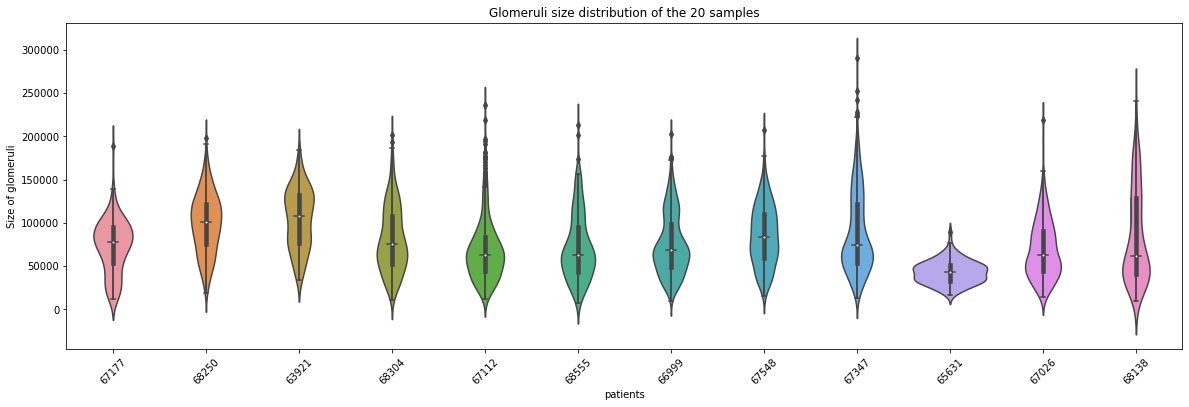

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the CSV file
df = pd.read_csv('./Final_files/Glomerulus_sizes_patient_20samples.csv')

# Set the figure size
fig, ax = plt.subplots(figsize=(20, 6))

# Create the violin plot using seaborn
sns.violinplot(data=df, ax=ax)
# Add a scatter plot to show all the data points
#sns.stripplot(data=df, jitter=True, color='black', size=3, ax=ax)
# Add a boxplot to show the quartiles and median
sns.boxplot(data=df, ax=ax, width=0.1, boxprops=dict(facecolor='None'))

# Add labels to the chart
ax.set_title('Glomeruli size distribution of the 20 samples')
ax.set_xlabel('patients')
ax.set_ylabel('Size of glomeruli')

# Rotate the x-tick labels
plt.xticks(rotation=45)

# Show the chart
plt.show()